# Classificação de Ataques de Rede com Random Forest e SVM

## Introdução

A segurança de redes é uma preocupação crescente no cenário tecnológico atual. Com a proliferação de dispositivos conectados e a crescente sofisticação das ameaças cibernéticas, a detecção de intrusões tornou-se um componente crítico para a proteção de sistemas e dados. Um sistema de detecção de intrusões (IDS) eficaz é essencial para identificar e responder a atividades maliciosas, garantindo a integridade, confidencialidade e disponibilidade das informações.

Neste contexto, a utilização de técnicas de aprendizado de máquina tem se mostrado promissora para aprimorar a capacidade dos IDSs em reconhecer padrões de ataques e tráfego anômalo. Entre os diversos datasets disponíveis para pesquisa em segurança de rede, o CIC-IDS2017 (Canadian Institute for Cybersecurity - Intrusion Detection System 2017) destaca-se por sua abrangência e realismo. Ele oferece uma representação detalhada do tráfego de rede, incluindo tanto atividades benignas quanto uma variedade de ataques comuns, como DoS (Denial of Service), DDoS (Distributed Denial of Service), Port Scan e ataques de força bruta. A relevância deste dataset reside em sua capacidade de simular cenários de rede próximos aos ambientes reais, o que permite o desenvolvimento e a avaliação de modelos de detecção de intrusões mais robustos e precisos.

Este notebook tem como objetivo explorar a aplicação de dois algoritmos de aprendizado de máquina amplamente utilizados para tarefas de classificação: Random Forest e Support Vector Machine (SVM). Através da utilização do dataset CIC-IDS2017, buscaremos classificar diferentes tipos de ataques de rede, avaliando o desempenho de cada modelo em termos de métricas como acurácia, precisão, recall e F1-score. Além disso, a análise da importância das features será realizada para identificar quais características do tráfego de rede são mais relevantes para a detecção eficaz desses ataques, fornecendo insights valiosos para futuras otimizações e desenvolvimento de sistemas de segurança.

## Importando Bibliotecas Essenciais


In [85]:
# -*- coding: utf-8 -*-
# from google.colab import drive
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, recall_score, precision_score # métricas para classificação
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif # para seleção de características
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.datasets import make_classification


## Carregamento e Visão Geral dos Dados

### Carregando dataset

In [86]:
# drive.mount('/content/drive')

data1 = pd.read_csv('CICIDS2017/Monday-WorkingHours.pcap_ISCX.csv')
data2 = pd.read_csv('CICIDS2017/Tuesday-WorkingHours.pcap_ISCX.csv')
data3 = pd.read_csv('CICIDS2017/Wednesday-workingHours.pcap_ISCX.csv')
data4 = pd.read_csv('CICIDS2017/Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv')
data5 = pd.read_csv('CICIDS2017/Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv')
data6 = pd.read_csv('CICIDS2017/Friday-WorkingHours-Morning.pcap_ISCX.csv')
data7 = pd.read_csv('CICIDS2017/Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv')
data8 = pd.read_csv('CICIDS2017/Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv')

datalist = [data1,data2,data3,data4,data5,data6,data7,data8]
data = pd.concat(datalist) #empilhando dados

for d in datalist:
  del d # apaga cada elemento do datalist
del datalist # apaga o datalist inicial

### Análise dos dados

In [87]:
print(f"Shape dos dados: {data.shape}")
data.info()

Shape dos dados: (2830743, 79)
<class 'pandas.core.frame.DataFrame'>
Index: 2830743 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 1

In [88]:
print("Primeiras linhas dos dados:")
data.head()

Primeiras linhas dos dados:


,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,49188,4,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,49188,1,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,49486,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [89]:
print("Tamanho do dataset")
print(f"Linhas: {data.shape[0]}")
print(f"Colunas: {data.shape[1]}")

Tamanho do dataset
Linhas: 2830743
Colunas: 79


## Análise Exploratória dos Dados

### Distribuição das Classes de Ataque


Distribuição das Classes de Ataque:


C:\Users\JHONATAS\AppData\Local\Temp\ipykernel_7548\2017308550.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


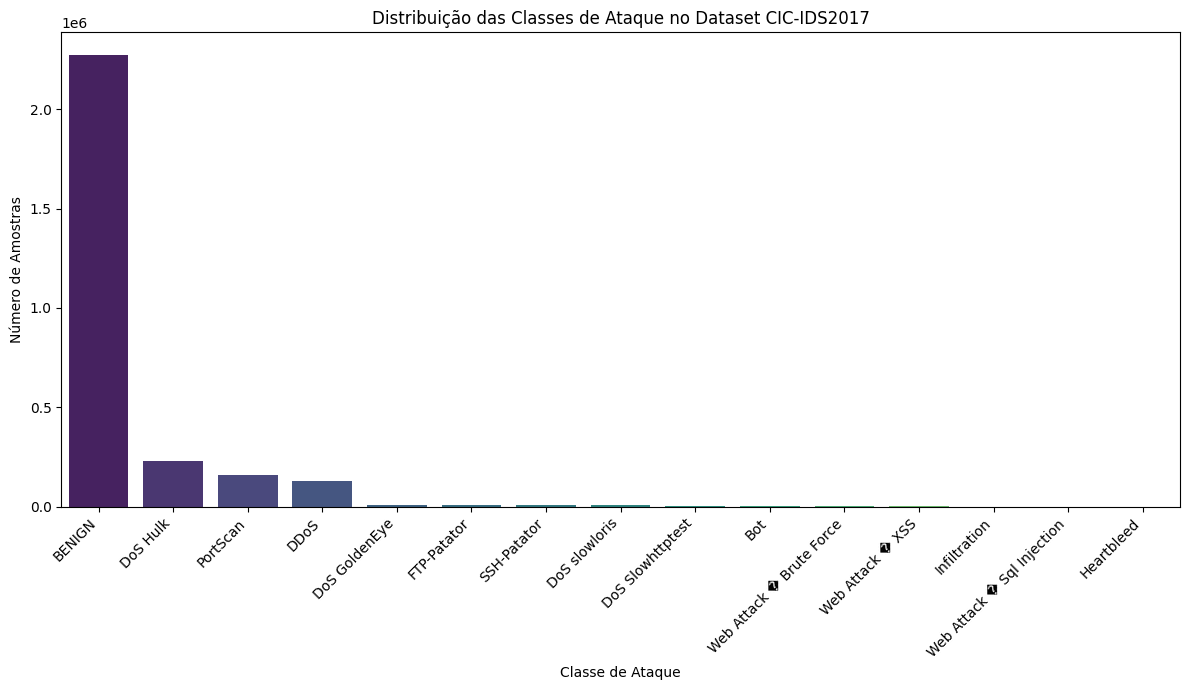

In [90]:
print("Distribuição das Classes de Ataque:")

label_counts = data[' Label'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribuição das Classes de Ataque no Dataset CIC-IDS2017')
plt.xlabel('Classe de Ataque')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Análise dos Valores Ausentes e Infinitos

In [91]:
print("\nAnálise de Valores Ausentes:")
valores_ausentes = data.isnull().sum()
porcentagem_ausentes = (data.isnull().sum() / len(data)) * 100
missing_data = pd.DataFrame({'Contagem Ausente': valores_ausentes, 'Porcentagem Ausente (%)': porcentagem_ausentes})
print(missing_data[missing_data['Contagem Ausente'] > 0].sort_values(by='Porcentagem Ausente (%)', ascending=False))



Análise de Valores Ausentes:
              Contagem Ausente  Porcentagem Ausente (%)
Flow Bytes/s              1358                 0.047973


In [92]:
data_temp = data.replace([np.inf, -np.inf], np.nan)
count_valores_infinitos = data_temp.isnull().sum() - valores_ausentes # Contagem de novos NaNs que eram infinitos
porcentagem_valores_infinitos = (count_valores_infinitos / len(data)) * 100
infinite_data = pd.DataFrame({'Contagem Infinitos': count_valores_infinitos, 'Porcentagem Infinitos (%)': porcentagem_valores_infinitos})
print("\nAnálise de Valores Infinitos:")
print(infinite_data[infinite_data['Contagem Infinitos'] > 0].sort_values(by='Porcentagem Infinitos (%)', ascending=False))



Análise de Valores Infinitos:
                 Contagem Infinitos  Porcentagem Infinitos (%)
 Flow Packets/s                2867                   0.101281
Flow Bytes/s                   1509                   0.053308


## Organizando nome das colunas

### Removendo espaços, pontos, barras, hífens e converter letras para minúsculas


In [93]:
# removendo espaços, pontos, barras, hífens e converter letras para minúsculas
data.columns = data.columns.str.lower().str.strip().str.replace(' ', '_').str.replace('.', '', regex=False).str.replace('/', '_').str.replace('-', '_')
print(f"Nomes de colunas padronizados (primeiros 5): {data.columns.tolist()[:5]}")

Nomes de colunas padronizados (primeiros 5): ['destination_port', 'flow_duration', 'total_fwd_packets', 'total_backward_packets', 'total_length_of_fwd_packets']


### Traduzindo nome das colunas

In [94]:
colunas_traducao = {
    'destination_port': 'porta_destino',
    'flow_duration': 'duracao_fluxo',
    'total_fwd_packets': 'total_pacotes_fwd',
    'total_backward_packets': 'total_pacotes_bwd',
    'total_length_of_fwd_packets': 'tamanho_total_pacotes_fwd',
    'total_length_of_bwd_packets': 'tamanho_total_pacotes_bwd',
    'fwd_packet_length_max': 'tam_pacote_fwd_max',
    'fwd_packet_length_min': 'tam_pacote_fwd_min',
    'fwd_packet_length_mean': 'tam_pacote_fwd_media',
    'fwd_packet_length_std': 'tam_pacote_fwd_std',
    'bwd_packet_length_max': 'tam_pacote_bwd_max',
    'bwd_packet_length_min': 'tam_pacote_bwd_min',
    'bwd_packet_length_mean': 'tam_pacote_bwd_media',
    'bwd_packet_length_std': 'tam_pacote_bwd_std',
    'flow_bytes_s': 'fluxo_bytes_s',
    'flow_packets_s': 'fluxo_pacotes_s',
    'flow_iat_mean': 'fluxo_iat_media',
    'flow_iat_std': 'fluxo_iat_std',
    'flow_iat_max': 'fluxo_iat_max',
    'flow_iat_min': 'fluxo_iat_min',
    'fwd_iat_total': 'fwd_iat_total',
    'fwd_iat_mean': 'fwd_iat_media',
    'fwd_iat_std': 'fwd_iat_std',
    'fwd_iat_max': 'fwd_iat_max',
    'fwd_iat_min': 'fwd_iat_min',
    'bwd_iat_total': 'bwd_iat_total',
    'bwd_iat_mean': 'bwd_iat_media',
    'bwd_iat_std': 'bwd_iat_std',
    'bwd_iat_max': 'bwd_iat_max',
    'bwd_iat_min': 'bwd_iat_min',
    'fwd_psh_flags': 'fwd_psh_flags',
    'bwd_psh_flags': 'bwd_psh_flags',
    'fwd_urg_flags': 'fwd_urg_flags',
    'bwd_urg_flags': 'bwd_urg_flags',
    'fwd_header_length': 'tam_cabecalho_fwd',
    'bwd_header_length': 'tam_cabecalho_bwd',
    'fwd_packets_s': 'fwd_pacotes_s',
    'bwd_packets_s': 'bwd_pacotes_s',
    'min_packet_length': 'tam_pacote_min',
    'max_packet_length': 'tam_pacote_max',
    'packet_length_mean': 'tam_pacote_media',
    'packet_length_std': 'tam_pacote_std',
    'packet_length_variance': 'variancia_tam_pacote',
    'fin_flag_count': 'contagem_fin_flag',
    'syn_flag_count': 'contagem_syn_flag',
    'rst_flag_count': 'contagem_rst_flag',
    'psh_flag_count': 'contagem_psh_flag',
    'ack_flag_count': 'contagem_ack_flag',
    'urg_flag_count': 'contagem_urg_flag',
    'cwe_flag_count': 'contagem_cwe_flag',
    'ece_flag_count': 'contagem_ece_flag',
    'down_up_ratio': 'down_up_ratio',
    'average_packet_size': 'tam_medio_pacote',
    'avg_fwd_segment_size': 'tam_medio_segmento_fwd',
    'avg_bwd_segment_size': 'tam_medio_segmento_bwd',
    'fwd_header_length1': 'tam_cabecalho_fwd1',
    'fwd_avg_bytes_bulk': 'fwd_bytes_bulk_media',
    'fwd_avg_packets_bulk': 'fwd_pacotes_bulk_media',
    'fwd_avg_bulk_rate': 'fwd_taxa_bulk_media',
    'bwd_avg_bytes_bulk': 'bwd_bytes_bulk_media',
    'bwd_avg_packets_bulk': 'bwd_pacotes_bulk_media',
    'bwd_avg_bulk_rate': 'bwd_taxa_bulk_media',
    'subflow_fwd_packets': 'subfluxo_pacotes_fwd',
    'subflow_fwd_bytes': 'subfluxo_bytes_fwd',
    'subflow_bwd_packets': 'subfluxo_pacotes_bwd',
    'subflow_bwd_bytes': 'subfluxo_bytes_bwd',
    'init_win_bytes_forward': 'bytes_janela_inicial_fwd',
    'init_win_bytes_backward': 'bytes_janela_inicial_bwd',
    'act_data_pkt_fwd': 'pacotes_dados_ativos_fwd',
    'min_seg_size_forward': 'tam_min_segmento_fwd',
    'active_mean': 'media_ativo',
    'active_std': 'std_ativo',
    'active_max': 'max_ativo',
    'active_min': 'min_ativo',
    'idle_mean': 'media_ocioso',
    'idle_std': 'std_ocioso',
    'idle_max': 'max_ocioso',
    'idle_min': 'min_ocioso',
    'label': 'rotulo'
}

data.rename(columns=colunas_traducao, inplace=True)

## Pré-Processamento dos dados

### Substituir valores infinitos (positivos e negativos) por NaN


In [95]:
print("Número de linhas com valores infinitos:")
print(data.isin([np.inf, -np.inf]).any(axis=1).sum())

Número de linhas com valores infinitos:
2867


In [96]:
print("Substituindo valores infinitos por NaN (valor ausente)")
data.replace([np.inf, -np.inf], np.nan, inplace=True) # substitui por NAN (valor ausente)

Substituindo valores infinitos por NaN (valor ausente)


### Remover linhas com valores ausentes (NaN)

In [97]:
print(f"Número de linhas antes da remoção de NaNs: {len(data)}")
print(f"Número de linhas com valores ausentes: {data.isnull().any(axis=1).sum()}")
data.dropna(inplace=True)
print('\nLinhas com NaN removidas\n')
print(f"Número de linhas após remoção de NaNs: {len(data)}")
print(f"Total de NaNs após a remoção: {data.isnull().sum().sum()}")

Número de linhas antes da remoção de NaNs: 2830743
Número de linhas com valores ausentes: 2867

Linhas com NaN removidas

Número de linhas após remoção de NaNs: 2827876
Total de NaNs após a remoção: 0


### Remover linhas duplicadas

In [98]:
print('Quantidade de linhas duplicadas: '+ str(data.duplicated().sum()))
data.drop_duplicates(inplace=True)
print('Linhas duplicadas removidas. \nQuantidade após remoção: '+ str(data.duplicated().sum()))

Quantidade de linhas duplicadas: 307078
Linhas duplicadas removidas. 
Quantidade após remoção: 0


### Limpeza dos Rótulos (Label)

In [99]:
data['rotulo'] = data['rotulo'].str.replace('�', '-') # Para substituir por -
data['rotulo'] = data['rotulo'].str.strip() # Remover espaços em branco
print("Valores únicos na coluna 'rotulo' após strip:", data['rotulo'].unique())

Valores únicos na coluna 'rotulo' após strip: ['BENIGN' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris' 'DoS Slowhttptest'
 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed' 'Web Attack - Brute Force'
 'Web Attack - XSS' 'Web Attack - Sql Injection' 'Infiltration' 'Bot'
 'PortScan' 'DDoS']


## Balanceamento Das Classes

### Distribuição das classes

In [100]:
print("Distribuição de rótulos antes da codificação:")
print(data['rotulo'].value_counts())

Distribuição de rótulos antes da codificação:
rotulo
BENIGN                        2095057
DoS Hulk                       172846
DDoS                           128014
PortScan                        90694
DoS GoldenEye                   10286
FTP-Patator                      5931
DoS slowloris                    5385
DoS Slowhttptest                 5228
SSH-Patator                      3219
Bot                              1948
Web Attack - Brute Force         1470
Web Attack - XSS                  652
Infiltration                       36
Web Attack - Sql Injection         21
Heartbleed                         11
Name: count, dtype: int64


### Balanceando Classes

In [101]:
ataques_agrupados = {
    'BENIGN': 'Tráfego Normal',
    'DoS Hulk': 'Ataque DoS/DDoS',
    'DDoS': 'Ataque DoS/DDoS',
    'PortScan': 'Ataque de Varredura',
    'DoS GoldenEye': 'Ataque DoS/DDoS',
    'FTP-Patator': 'Outros Ataques/Raros',
    'DoS slowloris': 'Ataque DoS/DDoS',
    'DoS Slowhttptest': 'Ataque DoS/DDoS',
    'SSH-Patator': 'Outros Ataques/Raros',
    'Bot': 'Outros Ataques/Raros',
    'Web Attack - Brute Force': 'Outros Ataques/Raros',
    'Web Attack - XSS': 'Outros Ataques/Raros',
    'Infiltration': 'Outros Ataques/Raros',
    'Web Attack - Sql Injection': 'Outros Ataques/Raros',
    'Heartbleed': 'Outros Ataques/Raros',
}

data['rotulo'] = data['rotulo'].map(ataques_agrupados).fillna('Outros Ataques/Raros')


### Verificação da Distribuição de Classes após Balanceamento

In [102]:
print("Balanceamento de classes após agrupamento:")
print(data['rotulo'].value_counts())

Balanceamento de classes após agrupamento:
rotulo
Tráfego Normal          2095057
Ataque DoS/DDoS          321759
Ataque de Varredura       90694
Outros Ataques/Raros      13288
Name: count, dtype: int64


### Distribuição das Classes de Ataque após Balanceamento por Agrupamento

Distribuição das Classes de Ataque:


C:\Users\JHONATAS\AppData\Local\Temp\ipykernel_7548\784653155.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


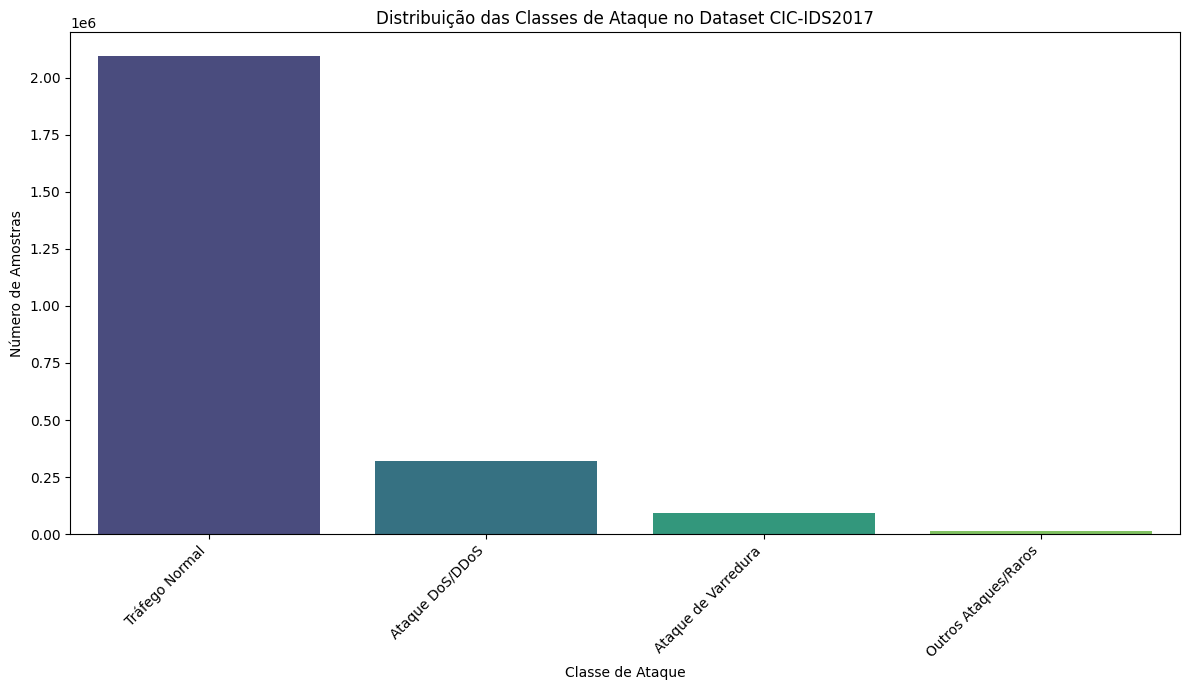

In [103]:
print("Distribuição das Classes de Ataque:")

label_counts = data['rotulo'].value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribuição das Classes de Ataque no Dataset CIC-IDS2017')
plt.xlabel('Classe de Ataque')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Separação dos Dados

### Separação das features e target

In [104]:
X = data.drop('rotulo', axis=1) # Características
y = data['rotulo']              # Rotulo/Target/Label

del data

### Encoder = Transformar o rótulo de string para inteiro

Utilizamos o `LabelEncoder` para converter os rótulos das classes, que estão em formato de texto, para valores inteiros. Essa transformação é necessária porque algoritmos como Random Forest e SVM exigem que os rótulos estejam em formato numérico para o treinamento do modelo.


In [105]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"Classes originais: {label_encoder.classes_}")
print(f"Classes codificadas: {np.unique(y_encoded)}")
print(f"Distribuição das classes codificadas antes do balanceamento:\n{pd.Series(y_encoded).value_counts()}")


Classes originais: ['Ataque DoS/DDoS' 'Ataque de Varredura' 'Outros Ataques/Raros'
 'Tráfego Normal']
Classes codificadas: [0 1 2 3]
Distribuição das classes codificadas antes do balanceamento:
3    2095057
0     321759
1      90694
2      13288
Name: count, dtype: int64


### Remover colunas não numéricas de X

In [106]:
numeric_cols_X = X.select_dtypes(include=np.number).columns
X = X[numeric_cols_X]

print(f"\nShape de X (features): {X.shape}")
print(f"Shape de y (rótulos): {y_encoded.shape}")



Shape de X (features): (2520798, 78)
Shape de y (rótulos): (2520798,)


### Diminuir a Precisão (tamanho) dos Dados

In [107]:
for col in X.columns:
    if X[col].dtype == 'float64':
        X[col] = X[col].astype('float32')
    elif X[col].dtype == 'int64':
        X[col] = X[col].astype('int32')

## Divisão de Treino e Teste

### Divisão entre treino e teste

In [108]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y_encoded,
    test_size=0.3,
    random_state=42,
    stratify=y_encoded
)

del X, y_encoded, y 

print(f"\nShape do conjunto de treino (do dataset reduzido): X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Shape do conjunto de teste (do dataset reduzido): X_test={X_test.shape}, y_test={y_test.shape}")



Shape do conjunto de treino (do dataset reduzido): X_train=(1764558, 78), y_train=(1764558,)
Shape do conjunto de teste (do dataset reduzido): X_test=(756240, 78), y_test=(756240,)


## Escalonamento das features: Normalização e Padronização dos Dados

Nesta etapa, utilizamos o `StandardScaler` para padronizar as features do conjunto de dados, ou seja, ajustar cada feature para que tenha média 0 e desvio padrão 1. Esse processo é importante para garantir que todas as variáveis estejam na mesma escala, evitando que atributos com valores maiores tenham mais influência no modelo. O escalonamento é ajustado apenas nos dados de treino e aplicado aos dados de teste, prevenindo vazamento de informação. Após a transformação, os novos conjuntos escalonados são convertidos novamente para DataFrames, preservando os nomes das colunas originais.


In [109]:
print("\nEscalonando as características (StandardScaler)...")
scaler = StandardScaler()
X_train_escalonado = scaler.fit_transform(X_train)
X_test_escalonado = scaler.transform(X_test)



Escalonando as características (StandardScaler)...


In [110]:
X_train_escalonado = pd.DataFrame(X_train_escalonado, columns=X_train.columns)
X_test_escalonado = pd.DataFrame(X_test_escalonado, columns=X_test.columns)

del X_train, X_test

### Removendo colunas sem variância de dados

In [111]:
print("Verificando e removendo colunas com variância zero")
variances = X_train_escalonado.var()
constant_columns = variances[variances == 0].index.tolist()

if constant_columns:
    print(f"Colunas com variância zero encontradas e removidas: {constant_columns}")
    X_train_escalonado = X_train_escalonado.drop(columns=constant_columns)
    X_test_escalonado = X_test_escalonado.drop(columns=constant_columns)
else:
    print("Nenhuma coluna com variância zero encontrada.")

print(f"Shape de X_train_escalonado após remoção de colunas constantes: {X_train_escalonado.shape}")
print(f"Shape de X_test_escalonado após remoção de colunas constantes: {X_test_escalonado.shape}")

Verificando e removendo colunas com variância zero
Colunas com variância zero encontradas e removidas: ['bwd_psh_flags', 'bwd_urg_flags', 'fwd_bytes_bulk_media', 'fwd_pacotes_bulk_media', 'fwd_taxa_bulk_media', 'bwd_bytes_bulk_media', 'bwd_pacotes_bulk_media', 'bwd_taxa_bulk_media']
Shape de X_train_escalonado após remoção de colunas constantes: (1764558, 70)
Shape de X_test_escalonado após remoção de colunas constantes: (756240, 70)


## Seleção de Features

Nesta etapa, aplicamos a técnica de seleção de características utilizando o `SelectKBest`. O objetivo é selecionar as 30 features mais relevantes do conjunto de dados, de acordo com uma função estatística de avaliação. Esse processo ajuda a reduzir a dimensionalidade do dataset, eliminando atributos menos importantes, o que pode melhorar o desempenho e a interpretabilidade dos modelos de machine learning. Após a seleção, mostramos quantas e quais features foram escolhidas para compor os dados de treino e teste.


In [ ]:
print("Realizando Seleção de Características com SelectKBest")
print(f"Número de características originais: {X_train_escalonado.shape[1]}")

k_features = 30 

selector = SelectKBest(f_classif, k=k_features)
X_train_selecionado = selector.fit_transform(X_train_escalonado, y_train)
X_test_selecionado = selector.transform(X_test_escalonado)

del  X_test_escalonado

features_selecionadas = selector.get_support()
nomes_features_selecionadass = X_train_escalonado.columns[features_selecionadas]

del X_train_escalonado


print(f"Número de características selecionadas: {X_train_selecionado.shape[1]}")
print(f"Características selecionadas:\n{nomes_features_selecionadass.tolist()}")



Realizando Seleção de Características com SelectKBest
Número de características originais: 70
Número de características selecionadas: 30
Características selecionadas:
['porta_destino', 'duracao_fluxo', 'tam_pacote_bwd_max', 'tam_pacote_bwd_min', 'tam_pacote_bwd_media', 'tam_pacote_bwd_std', 'fluxo_iat_media', 'fluxo_iat_std', 'fluxo_iat_max', 'fwd_iat_total', 'fwd_iat_media', 'fwd_iat_std', 'fwd_iat_max', 'bwd_iat_std', 'bwd_iat_max', 'bwd_pacotes_s', 'tam_pacote_min', 'tam_pacote_max', 'tam_pacote_media', 'tam_pacote_std', 'variancia_tam_pacote', 'contagem_fin_flag', 'contagem_psh_flag', 'contagem_ack_flag', 'tam_medio_pacote', 'tam_medio_segmento_bwd', 'media_ocioso', 'std_ocioso', 'max_ocioso', 'min_ocioso']


## Aplicação SMOTE

Apesar do balanceamento inicial realizado anteriormente, ainda foi observada uma grande desproporção entre as classes do conjunto de treino, com algumas categorias sendo representadas por muito menos exemplos do que outras. Esse desbalanceamento pode prejudicar o desempenho do modelo, pois modelos de machine learning tendem a favorecer as classes majoritárias.

Para contornar esse problema, aplicamos o método SMOTE (Synthetic Minority Over-sampling Technique), que gera amostras sintéticas das classes minoritárias até que todas as classes tenham a mesma quantidade de exemplos no conjunto de treino. Dessa forma, garantimos que o modelo seja treinado de maneira mais equilibrada, aumentando suas chances de aprender a identificar corretamente todas as classes, inclusive as menos frequentes.

In [ ]:
print("\nAplicando SMOTE para balancear as classes no conjunto de treino selecionado...")
print(f"Distribuição das classes antes do SMOTE: {Counter(y_train)}")
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_selecionado, y_train)

print(f"Shape do conjunto de treino APÓS SMOTE: X_train_res={X_train_res.shape}, y_train_res={y_train_res.shape}")
print(f"Distribuição das classes após SMOTE: {Counter(y_train_res)}")



Aplicando SMOTE para balancear as classes no conjunto de treino selecionado...
Distribuição das classes antes do SMOTE: Counter({np.int64(3): 1466539, np.int64(0): 225231, np.int64(1): 63486, np.int64(2): 9302})
Shape do conjunto de treino APÓS SMOTE: X_train_res=(5866156, 30), y_train_res=(5866156,)
Distribuição das classes após SMOTE: Counter({np.int64(3): 1466539, np.int64(0): 1466539, np.int64(1): 1466539, np.int64(2): 1466539})


### Distribuição das Classes de Ataque após Balanceamento por SMOTE

Distribuição das Classes de Ataque:


C:\Users\JHONATAS\AppData\Local\Temp\ipykernel_7548\3581940983.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')


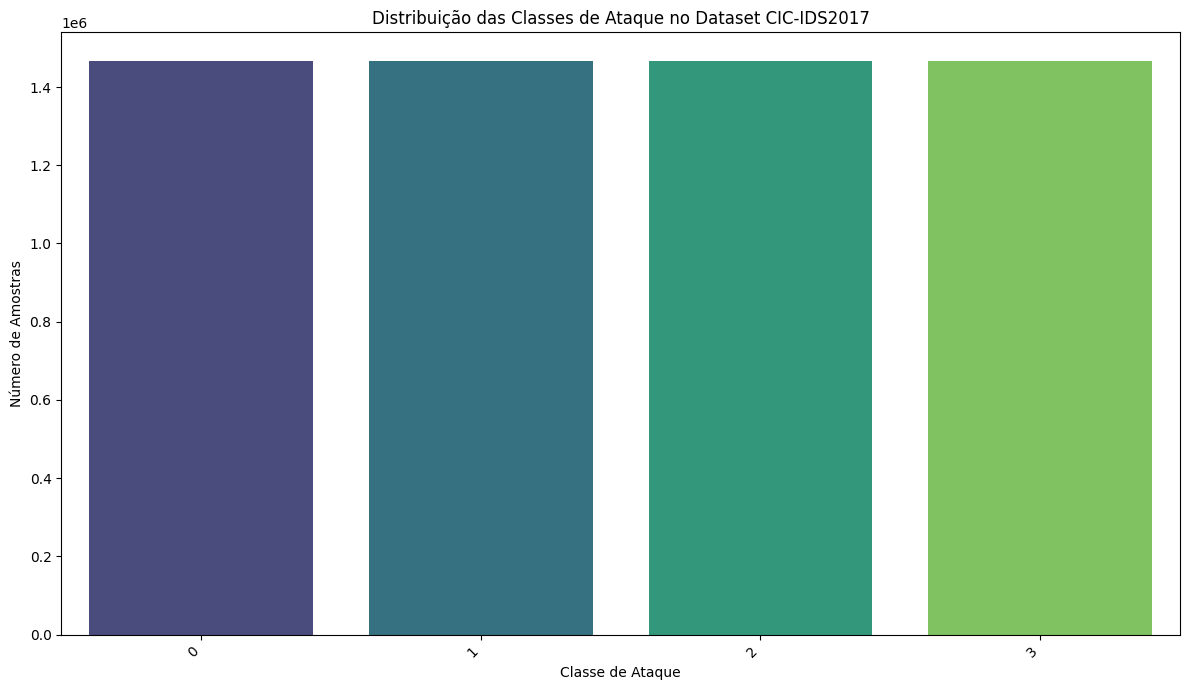

In [ ]:
print("Distribuição das Classes de Ataque:")

label_counts = pd.Series(y_train_res).value_counts()

plt.figure(figsize=(12, 7))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Distribuição das Classes de Ataque no Dataset CIC-IDS2017')
plt.xlabel('Classe de Ataque')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Treinamento e Avaliação Random Forest

### Instanciando o modelo

In [ ]:
random_forest_modelo = RandomForestClassifier(random_state=42, n_jobs=-1)


### Treinando e calculando o tempo de treinamento

In [ ]:
print("Iniciando treinamento do Random Forest")
start_time_random_forest = time.time()
random_forest_modelo.fit(X_train_res, y_train_res)
fim_time_random_forest = time.time()
tempo_treinamento_random_forest = fim_time_random_forest - start_time_random_forest
print(f"Tempo de treinamento do Random Forest: {tempo_treinamento_random_forest/60:.2f} minutos")


Iniciando treinamento do Random Forest


Tempo de treinamento do Random Forest: 10.50 minutos


### Fazendo Inferência e calculando o tempo de previsão

In [130]:
print("Realizando previsões com Random Forest")
start_time_previsao_random_forest = time.time()
y_pred_random_forest = random_forest_modelo.predict(X_test_selecionado) # Usar os dados de teste COM FEATURES SELECIONADAS
fim_time_previsao_random_forest = time.time()
tempo_previsao_random_forest = fim_time_previsao_random_forest - start_time_previsao_random_forest
print(f"Tempo de inferência do Random Forest: {tempo_previsao_random_forest:.2f} segundos")


Realizando previsões com Random Forest
Tempo de inferência do Random Forest: 2.32 segundos


## Avaliação de Desempenho do Random Forest

### Classification Report Random Forest

In [ ]:
print("Relatório de Classificação:\n", classification_report(y_test, y_pred_random_forest, target_names=label_encoder.classes_))

Relatório de Classificação:
                       precision    recall  f1-score   support

     Ataque DoS/DDoS       1.00      1.00      1.00     96528
 Ataque de Varredura       0.99      0.99      0.99     27208
Outros Ataques/Raros       0.79      0.95      0.87      3986
      Tráfego Normal       1.00      1.00      1.00    628518

            accuracy                           1.00    756240
           macro avg       0.94      0.99      0.96    756240
        weighted avg       1.00      1.00      1.00    756240



### Matriz de Confusão Random Forest

Matriz de Confusão:


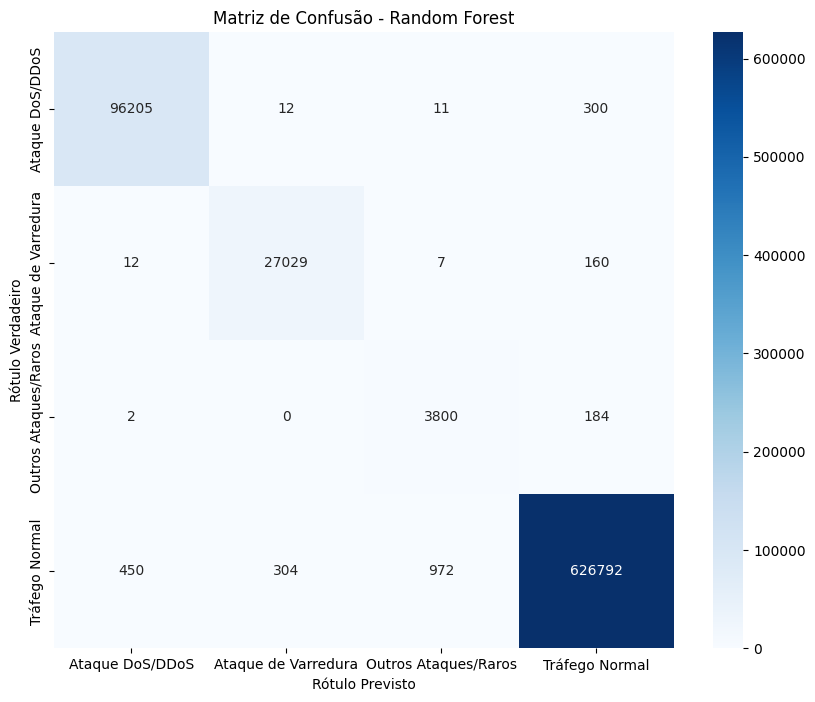

In [ ]:
print("Matriz de Confusão:")
cm_random_forest = confusion_matrix(y_test, y_pred_random_forest)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_random_forest, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão - Random Forest')
plt.xlabel('Rótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.show()

In [ ]:
#Acurácia, precisão, recall, F1-score por classe
print("Acurácia do Random Forest:", accuracy_score(y_test, y_pred_random_forest))
print("F1 Score do Random Forest:", f1_score(y_test, y_pred_random_forest, average='weighted'))
print("Precisão do Random Forest:", precision_score(y_test, y_pred_random_forest, average='weighted'))
print("Recall do Random Forest:", recall_score(y_test, y_pred_random_forest, average='weighted'))

Acurácia do Random Forest: 0.9968078916746007
F1 Score do Random Forest: 0.9968789757182734
Precisão do Random Forest: 0.9970291449636228
Recall do Random Forest: 0.9968078916746007


### Análise das Características


--- Análise da Importância das Características (Random Forest) ---


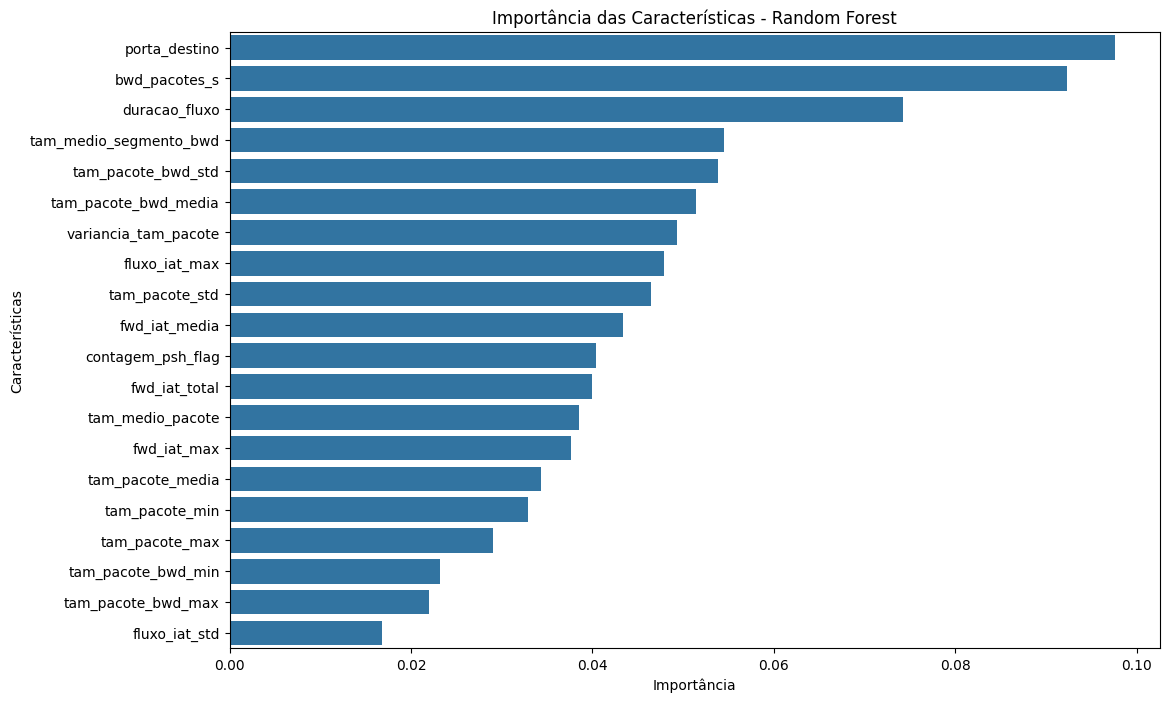

In [ ]:
print("\n--- Análise da Importância das Características (Random Forest) ---")
importancias = random_forest_modelo.feature_importances_
nomes_rotulos = nomes_features_selecionadass.tolist()
importancias_df = pd.DataFrame({'rotulo': nomes_rotulos, 'Importance': importancias})
importancias_df = importancias_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='rotulo', data=importancias_df.head(20)) # Exibir as 20 mais importantes
plt.title('Importância das Características - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Características')
plt.show()


## Treinamento e Avaliação SVM


### Instanciando o *modelo*

In [ ]:
svm_model = LinearSVC(random_state=42, max_iter=10000) 

### Treinando e calculando o tempo de **treinamento**

In [ ]:
print("Iniciando o treinamento do modelo SVM (LinearSVC)")
start_time_SVM = time.time()
svm_model.fit(X_train_res, y_train_res)

fim_time_SVM = time.time()
training_time = fim_time_SVM - start_time_SVM
print(f"Treinamento do SVM concluído em {training_time/60:.2f} minutos.")


Iniciando o treinamento do modelo SVM (LinearSVC)
Treinamento do SVM concluído em 23.84 minutos.


In [ ]:
horas = training_time // 3600
minutos = (training_time % 3600) // 60 
print(f"Tempo de treinamento do SVM: {horas} horas e {minutos} minutos.")

Tempo de treinamento do SVM: 0.0 horas e 23.0 minutos.


### Fazendo Inferência e calculando o tempo de previsão

In [ ]:
print("Fazendo previsões no conjunto de teste...")
start_time = time.time()
y_pred_SVM = svm_model.predict(X_test_selecionado)
end_time = time.time()
prediction_time = end_time - start_time
print(f"Previsões concluídas em {prediction_time:.2f} segundos.")


Fazendo previsões no conjunto de teste...
Previsões concluídas em 0.23 segundos.


## Avaliação de Desempenho do SVM

#### Classification Report SVM

In [ ]:
print("Relatório de Classificação SVM:")
print(classification_report(y_test, y_pred_SVM, target_names=label_encoder.classes_))

Relatório de Classificação SVM:
                      precision    recall  f1-score   support

     Ataque DoS/DDoS       0.87      0.90      0.88     96528
 Ataque de Varredura       0.65      1.00      0.79     27208
Outros Ataques/Raros       0.05      0.93      0.09      3986
      Tráfego Normal       1.00      0.85      0.92    628518

            accuracy                           0.86    756240
           macro avg       0.64      0.92      0.67    756240
        weighted avg       0.96      0.86      0.90    756240



#### Matriz de Confusão SVM

Matriz de Confusão:


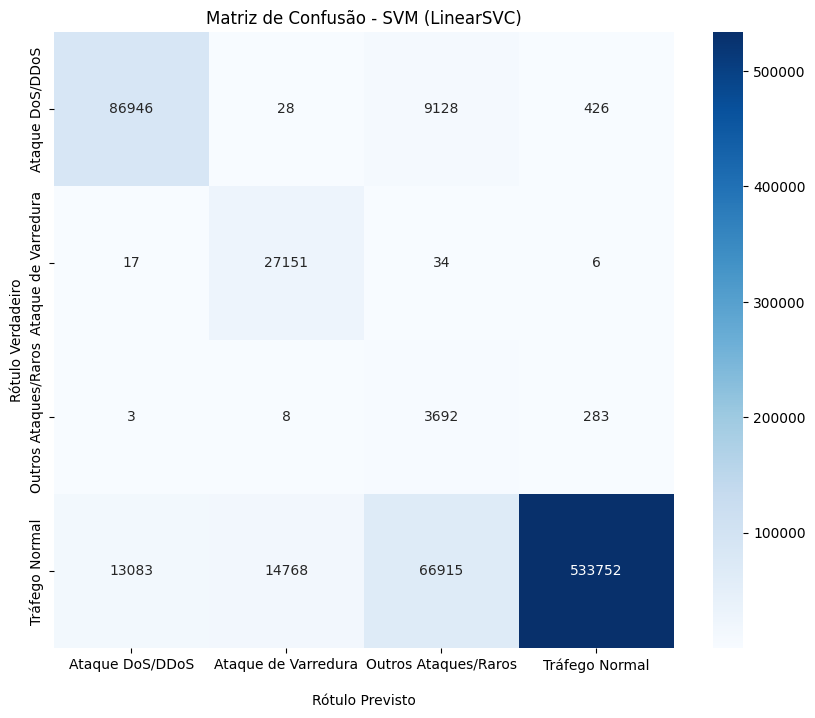

In [ ]:
print("Matriz de Confusão:")
cm_SVM = confusion_matrix(y_test, y_pred_SVM)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_SVM, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Matriz de Confusão - SVM (LinearSVC)')
plt.xlabel('\nRótulo Previsto')
plt.ylabel('Rótulo Verdadeiro')
plt.show()

In [ ]:
#Acurácia, precisão, recall, F1-score por classe
print("Acurácia do SVM(LinearSVC):", accuracy_score(y_test, y_pred_SVM))
print("F1 Score do SVM(LinearSVC):", f1_score(y_test, y_pred_SVM, average='weighted'))
print("Precisão do SVM(LinearSVC):", precision_score(y_test, y_pred_SVM, average='weighted'))
print("Recall   do SVM(LinearSVC):", recall_score(y_test, y_pred_SVM, average='weighted'))

Acurácia do SVM(LinearSVC): 0.8615532106209669
F1 Score do SVM(LinearSVC): 0.9044993951546986
Precisão do SVM(LinearSVC): 0.9644495652289158
Recall   do SVM(LinearSVC): 0.8615532106209669


### Análise das Características


--- Análise da Importância das Características (SVM) ---


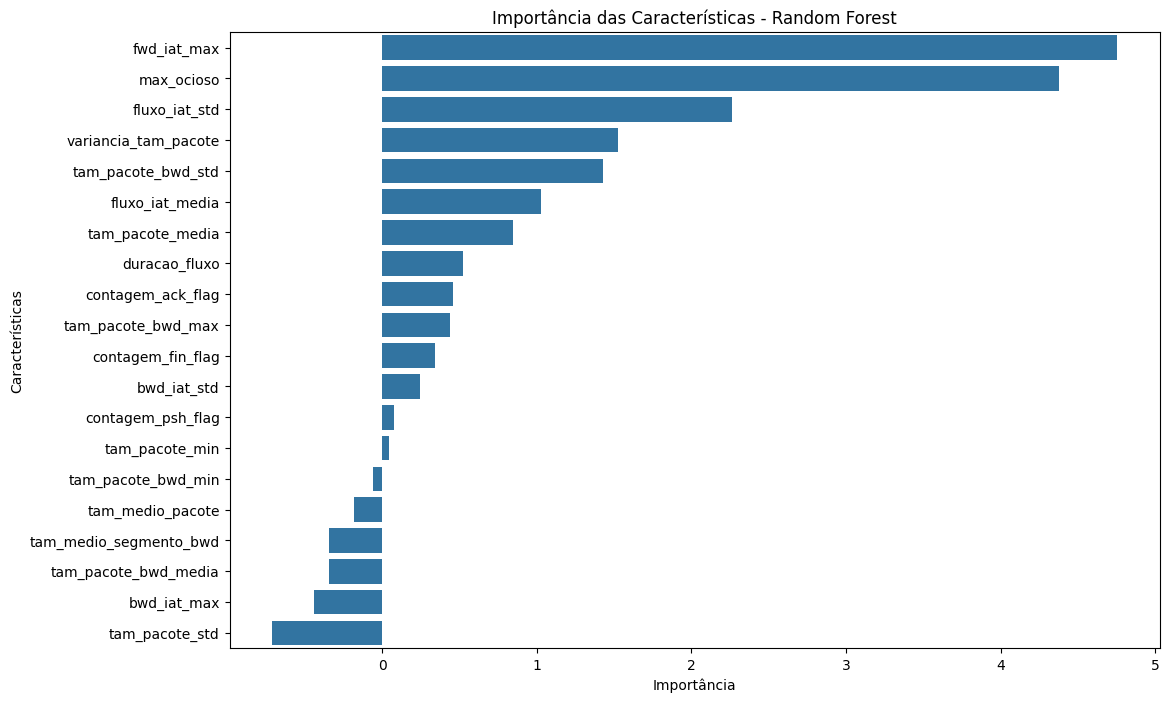


SVM Avaliado com sucesso!



In [ ]:
print("\n--- Análise da Importância das Características (SVM) ---")
importancias = svm_model.coef_[0]  # Coeficientes do modelo SVM
nomes_rotulos = nomes_features_selecionadass.tolist()
importancias_df = pd.DataFrame({'rotulo': nomes_rotulos, 'Importance': importancias})
importancias_df = importancias_df.sort_values(by='Importance', ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='rotulo', data=importancias_df.head(20)) # Exibir as 20 mais importantes
plt.title('Importância das Características - Random Forest')
plt.xlabel('Importância')
plt.ylabel('Características')
plt.show()
print("\nSVM Avaliado com sucesso!\n")


## Comparação entre Desempenhos

A análise e classificação de ataques de rede utilizando os modelos Random Forest e Support Vector Machine (SVM) no dataset CIC-IDS2017 revelaram diferenças significativas em seus desempenhos, tanto em termos de métricas de classificação quanto de eficiência computacional.



### Comparação Explícita dos Modelos:
Ao comparar o desempenho do Random Forest e do SVM (LinearSVC), observa-se que o Random Forest superou o SVM em todas as métricas de classificação avaliadas, apresentando as seguintes performances:

#### Random Forest:
* Acurácia: 0.8615532106209669
* F1 Score (ponderado): 0.9044993951546986
* Precisão (ponderado): 0.9644495652289158
* Recall (ponderado): 0.8615532106209669

#### SVM (LinearSVC):

* Acurácia: 0.8615532106209669
* F1 Score (ponderado): 0.9044993951546986
* Precisão (ponderado): 0.9644495652289158
* Recall    (ponderado): 0.8615532106209669

O modelo Random Forest se destacou na identificação precisa de diversos tipos de ataques e do tráfego normal, alcançando uma acurácia próxima de 100%. Suas altas pontuações de precisão, recall e F1-score para a maioria das classes, como "Ataque DoS/DDoS" e "Tráfego Normal" (onde todas as métricas atingiram 1.00), corroboram esse desempenho. Mesmo a classe minoritária "Outros Ataques/Raros" demonstrou um F1-score expressivo de 0.87, indicando a eficácia da técnica SMOTE no balanceamento dos dados de treinamento e na consequente capacidade do modelo de aprender padrões de ataques menos comuns.

Em contrapartida, o SVM (LinearSVC) apresentou um desempenho inferior, especialmente na classificação de classes minoritárias e ataques específicos. Apesar de ter um bom rendimento em classes majoritárias, como "Tráfego Normal" (com precisão de 1.00 e recall de 0.85), o F1-score para "Outros Ataques/Raros" foi notavelmente baixo (0.09), e para "Ataque de Varredura", obteve 0.79. Tais resultados sugerem que o SVM, mesmo após o balanceamento com SMOTE e a seleção de features, não conseguiu generalizar tão bem quanto o Random Forest para os padrões mais complexos ou subrepresentados no conjunto de dados.

### Eficiência Computacional:

#### Em relação ao tempo de execução, houve uma clara distinção entre os modelos:

- Tempo de Treinamento:
1. Random Forest: 10.50 minutos
2. SVM (LinearSVC): 23.84 minutos (ou 23.0 minutos)

- Tempo de Inferência:
1. Random Forest: 2.32 segundos
2. SVM (LinearSVC): 0.23 segundos

O treinamento do Random Forest foi mais rápido, levando 10.50 minutos, enquanto o SVM (LinearSVC) precisou de 23.84 minutos (ou aproximadamente 23.0 minutos). Contudo, na fase de inferência, o SVM (LinearSVC) demonstrou ser consideravelmente mais veloz, com um tempo de 0.23 segundos, em contraste com os 0.04 minutos (equivalente a 2.4 segundos) do Random Forest. Essa diferença na velocidade de inferência pode ser um fator determinante em aplicações de detecção de intrusão em tempo real, onde a agilidade é essencial.

### Considerações Finais:



O modelo Random Forest demonstrou uma capacidade quase perfeita de identificar corretamente os diferentes tipos de ataques e o tráfego normal, com uma acurácia de 0.99. Suas altas pontuações de precisão (0.99), recall (0.99) e F1-score (0.99) para a maioria das classes corroboram esse desempenho. Para as classes "Ataque DoS/DDoS" e "Tráfego Normal", todas as métricas (precisão, recall, F1-score) atingiram 1.00. Mesmo a classe minoritária "Outros Ataques/Raros", embora minoritária, apresentou um desempenho muito bom (F1-score de 0.87), indicando que a técnica SMOTE foi eficaz em balancear o conjunto de dados de treinamento e na consequente capacidade do modelo de aprender padrões de ataques menos frequentes.

Em contrapartida, o SVM (LinearSVC) apresentou um desempenho inferior, especialmente na classificação de classes minoritárias e ataques específicos. Apesar de ter um bom rendimento em classes majoritárias como "Tráfego Normal" (com precisão de 1.00 e recall de 0.85), a acurácia geral do SVM foi de 0.86. Notavelmente, o F1-score para a classe "Outros Ataques/Raros" foi muito baixo (0.09), e para "Ataque de Varredura", obteve um F1-score de 0.79. Tais resultados sugerem que o SVM, mesmo com o balanceamento do SMOTE e a seleção de features, não conseguiu generalizar tão bem quanto o Random Forest para os padrões mais complexos ou subrepresentados no conjunto de dados.